In [1]:
import sys
import os
import copy
import glob
import json
import shutil
import torch
import random
import secrets
import botorch
import scipy
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Sampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import gpytorch

from sklearn.model_selection import train_test_split
from botorch.acquisition import qUpperConfidenceBound

sys.path.append('/home/jgershon/git/cleo/')
import fragment_util
import pdb_util
from cleo import CLEO
from model_util import train_gp, evaluate_gp, seq_activity_dataset, save_gp, load_gp, GP
from optimization_util import *
aa2num = pdb_util.aa12num
num2aa = pdb_util.num2aa1

from sklearn.model_selection import train_test_split


# building dataset

# path to fragments for order
# df must have cols 'name' , 'fragment' , 'seq'
# fragment_csv = '/home/jgershon/Desktop/HYDROLASE/super/fragments_for_order.csv'

# data_csvs = [
#     '/home/jgershon/Desktop/HYDROLASE/super/training_data/round0_randomsample.csv',
# ]


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

raw_enz_df = pd.read_csv('./four-site_simplified_AA_data.csv')
enz_df = raw_enz_df[raw_enz_df['# Stop'] == 0]

/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cpu


(array([ 20.,  63., 156., 210., 243., 167.,  72.,  28.,  35.,   6.]),
 array([0.42114173, 0.47902756, 0.53691339, 0.59479921, 0.65268504,
        0.71057087, 0.76845669, 0.82634252, 0.88422835, 0.94211417,
        1.        ]),
 <BarContainer object of 10 artists>)

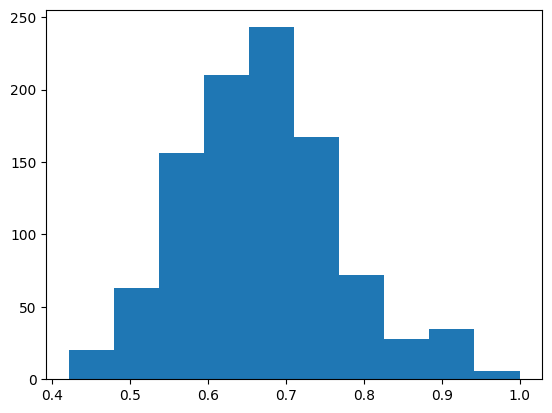

In [13]:
plt.hist(max_vals)

In [27]:

k = 50

topk_df = enz_df.sort_values('fitness',ascending=False)[:k]

### generating data splits for testing

In [69]:
# load data from the enzyme experiment
# ONLY RUN IF NEED TO GENERATE NEW DATASETS
write_new_datasets = False
if write_new_datasets:
    raw_enz_df = pd.read_csv('./four-site_simplified_AA_data.csv')
    enz_df = raw_enz_df[raw_enz_df['# Stop'] == 0]

    num_start = 250

    num_sampled_sets = 3
    datasets = {
        0:[],
        1:[],
        5:[],
        10:[],
    }

    for percent_positive in tqdm(datasets):
        while len(datasets[percent_positive]) < num_sampled_sets:

            pool, init = train_test_split(enz_df, test_size=num_start/len(enz_df))

            if percent_positive == round(init['active'].sum()/num_start * 100):
                datasets[percent_positive].append((init, pool))

    for pos in datasets:
        for init,pool in datasets[pos]:
            uid = secrets.token_hex(4)
            out_name = f'./arnold_data/{uid}_pos_start_{pos}'
            init.to_csv(f'{out_name}_init.csv')
            pool.to_csv(f'{out_name}_pool.csv')

In [54]:
torch.cuda.empty_cache()

### Sample starting data

now training model


100%|██████████| 1000/1000 [00:05<00:00, 185.48it/s]


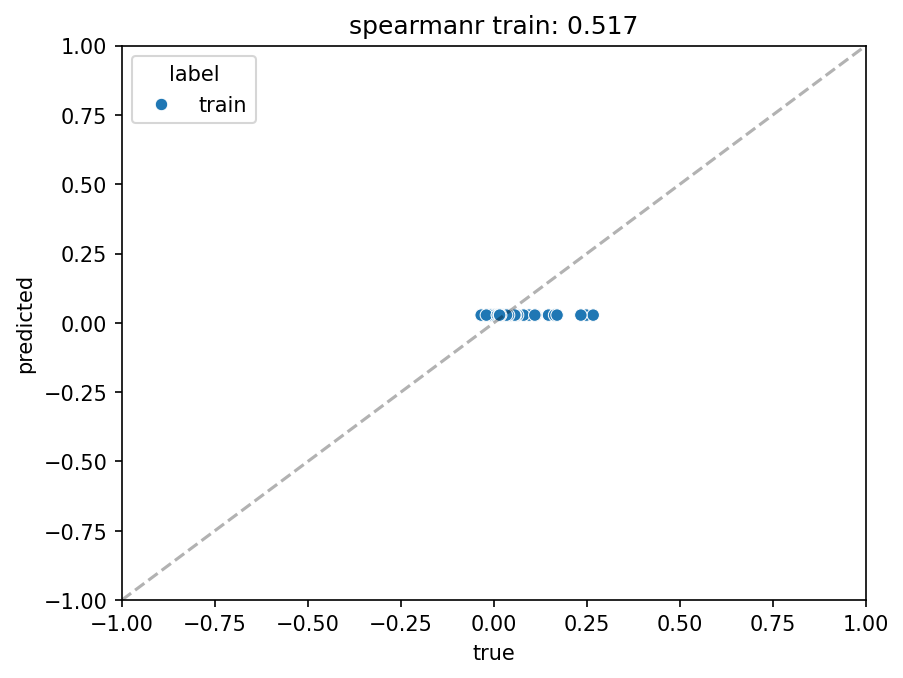

{'train_spearmanr': 0.5167610858632674}

In [57]:
# if training over one hot
training_iter = 1000
lr = 0.001

train_df = pd.read_csv('./arnold_data/52b94d16_pos_start_10_init.csv')

dataset = seq_activity_dataset(train_df, input_col='AAs', label_col='fitness')

train_x = dataset.featurized_seqs
train_y = dataset.activities

input_dim = dataset.featurized_seqs.shape[-1]
hidden_dim = 32

# define likelihood for sampling
train_params = {
    'train_x':train_x, 
    'train_y':train_y,
    'input_dim':input_dim,
    'hidden_dim':hidden_dim,
    'learning_rate':lr,
    'training_iter':training_iter,
}

model, loss_list = train_gp(train_params=train_params, device=device)
evaluate_gp(model.cpu(), dataset)

In [ ]:
'name','fragment','seq'

In [113]:
start_df

,Unnamed: 0,AAs,AA1,AA2,AA3,AA4,# Stop,fitness,active
0,167149,VDPL,V,D,P,L,0.0,0.012900,False
1,72681,HWAD,H,W,A,D,0.0,0.006343,False
2,184887,YCAH,Y,C,A,H,0.0,0.025498,False
3,67581,HHFR,H,H,F,R,0.0,0.044998,False
4,116872,NQYD,N,Q,Y,D,0.0,0.000015,False
...,...,...,...,...,...,...,...,...,...
159024,160754,TLCK,T,L,C,K,0.0,0.038838,False
159025,31079,DHYQ,D,H,Y,Q,0.0,-0.005414,False
159026,166895,VDAI,V,D,A,I,0.0,-0.001467,False
159027,148169,SCMV,S,C,M,V,0.0,0.042222,False


In [2]:
# if training over one hot

k = 5000

topk_df = enz_df.sort_values('fitness',ascending=False)[:k]
topk_dataset = seq_activity_dataset(topk_df, input_col='AAs', label_col='fitness')

datas = {
    'topk_spearmanr':[],
    'sample_size':[],
}

num_samples = 5
sample_sizes = [3000]

for sample_size in sample_sizes:

    for i in range(num_samples):

        training_iter = 500
        lr = 0.001
        sample = enz_df.sample(sample_size)
        dataset = seq_activity_dataset(sample, input_col='AAs', label_col='fitness')

        train_x = dataset.featurized_seqs
        train_y = dataset.activities

        input_dim = dataset.featurized_seqs.shape[-1]
        hidden_dim = 32

        # define likelihood for sampling
        train_params = {
            'train_x':train_x, 
            'train_y':train_y,
            'input_dim':input_dim,
            'hidden_dim':hidden_dim,
            'learning_rate':lr,
            'training_iter':training_iter,
        }

        model, loss_list = train_gp(train_params=train_params,device=device)
        # metadata = evaluate_gp(model.cpu(), dataset, show_plot=False)
        
        # get top1k spearmanr
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            etopk = model.posterior(topk_dataset.featurized_seqs.to(device))
        topk_spearmanr = scipy.stats.spearmanr(topk_dataset.activities, etopk.mean.cpu())[0]
        
        datas['topk_spearmanr'].append(topk_spearmanr)
        datas['sample_size'].append(sample_size)


/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


now training model : cpu


100%|██████████| 500/500 [18:56<00:00,  2.27s/it]


now training model : cpu


  0%|          | 2/500 [00:06<27:28,  3.31s/it]


KeyboardInterrupt: 

<Axes: xlabel='sample_size', ylabel='topk_spearmanr'>

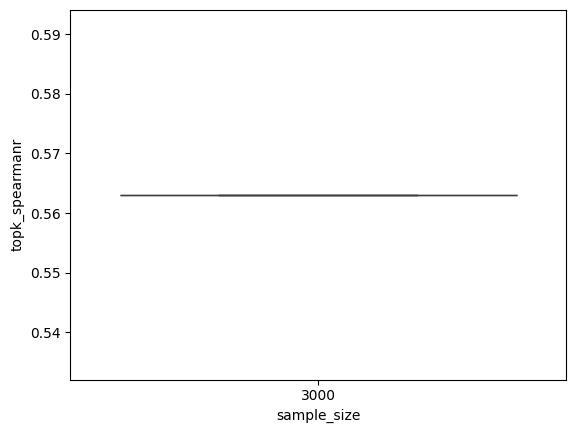

In [3]:
sns.boxplot(data=datas, x='sample_size',y='topk_spearmanr')

0.03125

In [51]:
enz_df.sort_values('fitness',ascending=False)

,AAs,AA1,AA2,AA3,AA4,# Stop,fitness,active
12849,AIKG,A,I,K,G,0.0,1.000000,True
22948,CLKG,C,L,K,G,0.0,0.932034,True
170146,VLKG,V,L,K,G,0.0,0.922559,True
13731,ALKG,A,L,K,G,0.0,0.916559,True
22074,CIKG,C,I,K,G,0.0,0.909769,True
...,...,...,...,...,...,...,...,...
72310,HVEE,H,V,E,E,0.0,-0.150831,False
185697,YDWD,Y,D,W,D,0.0,-0.153170,False
68302,HIWW,H,I,W,W,0.0,-0.160314,False
68563,HKMW,H,K,M,W,0.0,-0.162106,False


In [64]:
fragment_dictionary = {i+1:[(x,aa2num[x]) for x in num2aa] for i in range(4)}

# if training over one hot
training_iter = 1000
lr = 0.001


input_dim = 80 # fixed for right now
hidden_dim = 32



train_df = pd.read_csv('./arnold_data/52b94d16_pos_start_10_init.csv')

dataset = seq_activity_dataset(train_df, input_col='AAs', label_col='fitness')

train_x = dataset.featurized_seqs
train_y = dataset.activities



# define likelihood for sampling
train_params = {
    'train_x':train_x, 
    'train_y':train_y,
    'input_dim':input_dim,
    'hidden_dim':hidden_dim,
    'learning_rate':lr,
    'training_iter':training_iter,
}

model, loss_list = train_gp(train_params=train_params, device=device)

now training model


100%|██████████| 1000/1000 [00:05<00:00, 196.91it/s]


### BIG LOOP

In [ ]:
# get datasets to test
start_csvs = glob.glob('./arnold_data/*.csv')
uids = []
for x in start_csvs:
    uids.append(x.split('/')[-1].split('_pos')[0])
uids = list(set(uids))

top1k_df = enz_df.sort_values('fitness',ascending=False)[:5000]
top1k_dataset = seq_activity_dataset(top1k_df, input_col='AAs', label_col='fitness')


# make fragment dictionary
fragment_dictionary = {i+1:[(x,x) for x in num2aa] for i in range(4)}


# BO settings
num_rounds = 10
num_restarts = 3
qUCB_beta = 0.5
N = 16
q = 100
num_iter_acqf = 250
step_size = 0.05

# surrogate train settings
training_iter = 500
lr = 0.001
input_dim = 80 # fixed for right now
hidden_dim = 32


for uid in uids:
    
    for restart in range(num_restarts):

        test_run_id = secrets.token_hex(4)

        matches = glob.glob(f'./arnold_data/*{uid}_pos_start*')
        matches.sort()

        start_df = pd.read_csv(matches[0])
        pool_df = pd.read_csv(matches[1])

        train_df = pd.DataFrame({'seq':start_df['AAs'].tolist(),'fitness':start_df['fitness'].tolist()})

        run_meta_data = {
            'round':[],
            'train_spearmanr':[],
            'top1k_spearmanr':[],
            'top_candidate':[],
            'start_dataset':[],
            'test_run_id':[],

        }

        seq_meta_data = {
            'round':[],
            'seq':[],
            'fitness':[],
        }


        # BO ROUND STARTS
        for round_ in range(num_rounds):

            max_fitness = train_df['fitness'].max()
            print(f'round {round_+1} : max seen {max_fitness}')
            run_meta_data['round'].append(round_+1)
            run_meta_data['top_candidate'].append(max_fitness)
            run_meta_data['start_dataset'].append(uid)
            run_meta_data['test_run_id'].append(test_run_id)

            # first train model

            dataset = seq_activity_dataset(train_df, input_col='seq', label_col='fitness')

            train_x = dataset.featurized_seqs
            train_y = dataset.activities

            input_dim = dataset.featurized_seqs.shape[-1]

            train_params = {
                'train_x':train_x, 
                'train_y':train_y,
                'input_dim':input_dim,
                'hidden_dim':hidden_dim,
                'learning_rate':lr,
                'training_iter':training_iter,
            }

            model, loss_list = train_gp(train_params=train_params,device=device)

            # get train spearmanr
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                etrain = model.posterior(train_x.to(device))
            train_spearmanr = scipy.stats.spearmanr(train_y, etrain.mean.cpu())[0]

            # get top1k spearmanr
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                etop1k = model.posterior(top1k_dataset.featurized_seqs.to(device))
            top1k_spearmanr = scipy.stats.spearmanr(top1k_dataset.activities, etop1k.mean.cpu())[0]

            run_meta_data['train_spearmanr'].append(train_spearmanr)
            run_meta_data['top1k_spearmanr'].append(top1k_spearmanr)


            # optimize acqf
            acqf = qUpperConfidenceBound(model, 0.05)

            policy = policy_optimize_acquisition_function(acqf, fragment_dictionary, N=N, q=q, num_iter=num_iter_acqf, step_size=step_size, device=device)

            candidate_seqs = get_candidates_from_policy(policy, fragment_dictionary)

            # add seqs to dataframe
            to_add = {
                'seq':[],
                'fitness':[],
            }
            for c in candidate_seqs:
                if c[1] not in train_df['seq'].tolist():
                    tmp = pool_df[pool_df['AAs']==c[1]]
                    if len(tmp) == 0:
                        fitness = 0
                    else:
                        fitness = tmp['fitness'].tolist()[0]
                    to_add['seq'].append(c[1])
                    to_add['fitness'].append(fitness)
                    seq_meta_data['round'].append(round_+1)
                    seq_meta_data['seq'].append(c[1])
                    seq_meta_data['fitness'].append(fitness)

            to_add_df = pd.DataFrame(to_add)

            train_df = pd.concat([train_df,to_add_df])


            
        out = f'./arnold_data/run_metadata/dataset_{uid}_test_run_{test_run_id}'

        run_meta_data_df = pd.DataFrame(run_meta_data)
        run_meta_data_df.to_csv(f'{out}_run_meta_data.csv')

        seq_meta_data_df = pd.DataFrame(seq_meta_data)
        seq_meta_data_df.to_csv(f'{out}_seq_meta_data.csv')

round 1 : max seen 0.0540816681258149
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 207.21it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


done, max acquisition value: 0.045
round 2 : max seen 0.2574581196912963
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.25it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.13it/s]


done, max acquisition value: 0.033
round 3 : max seen 0.3724736313867443
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 188.06it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.034
round 4 : max seen 0.3724736313867443
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 189.32it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.031
round 5 : max seen 0.404601850259468
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 181.39it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.150
round 6 : max seen 0.7195693389668778
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 177.30it/s]


policy optimization over fragment space


  1%|          | 2/250 [00:00<00:19, 12.56it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.407
round 7 : max seen 0.7195693389668778
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.93it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.433
round 8 : max seen 0.7195693389668778
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.35it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.527
round 9 : max seen 0.7195693389668778
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 163.55it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.569
round 10 : max seen 0.9165593809430744
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 156.27it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.629
round 1 : max seen 0.0540816681258149
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 207.68it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.044
round 2 : max seen 0.4419156184136311
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 196.62it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.039
round 3 : max seen 0.4716704366015078
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 204.28it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


done, max acquisition value: 0.236
round 4 : max seen 0.5398174736749326
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.77it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.374
round 5 : max seen 0.6048215612890117
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 182.53it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.12it/s]


done, max acquisition value: 0.479
round 6 : max seen 0.6048215612890117
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.92it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.495
round 7 : max seen 0.6048215612890117
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 171.20it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.521
round 8 : max seen 0.6048215612890117
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 174.12it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.520
round 9 : max seen 0.6048215612890117
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 162.68it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.514
round 10 : max seen 0.6861784504516067
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 158.11it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.482
round 1 : max seen 0.0540816681258149
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 204.86it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.33it/s]


done, max acquisition value: 0.044
round 2 : max seen 0.3526371495141555
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 190.20it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.041
round 3 : max seen 0.7903253461919996
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 186.60it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


done, max acquisition value: 0.420
round 4 : max seen 0.7903253461919996
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 190.62it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.536
round 5 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 185.90it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.616
round 6 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 179.24it/s]


policy optimization over fragment space


 96%|█████████▌| 240/250 [00:18<00:00, 13.19it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.534
round 7 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 171.72it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.686
round 8 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.30it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.665
round 9 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 160.07it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.690
round 10 : max seen 0.7945158826470154
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 154.62it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.675
round 1 : max seen 0.1948656992294483
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.21it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.049
round 2 : max seen 0.6642770308248422
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 183.86it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.28it/s]


done, max acquisition value: 0.037
round 3 : max seen 0.6983345726396913
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 185.71it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.490
round 4 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 187.18it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


done, max acquisition value: 0.721
round 5 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.68it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.765
round 6 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 164.82it/s]


policy optimization over fragment space


  1%|          | 2/250 [00:00<00:20, 12.31it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.723
round 7 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 168.88it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.801
round 8 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.50it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.725
round 9 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 157.81it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.705
round 10 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 154.83it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.806
round 1 : max seen 0.1948656992294483
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 202.78it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.045
round 2 : max seen 0.4530854739229393
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 183.78it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.039
round 3 : max seen 0.4530854739229393
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 179.07it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.29it/s]


done, max acquisition value: 0.166
round 4 : max seen 0.4613334867024358
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 180.62it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.245
round 5 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 182.05it/s]


policy optimization over fragment space


  6%|▌         | 14/250 [00:01<00:17, 13.30it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


done, max acquisition value: 0.582
round 6 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 173.01it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.370
round 7 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.07it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.379
round 8 : max seen 0.6491613686978537
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.32it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.466
round 9 : max seen 0.6491613686978537
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 160.85it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.566
round 10 : max seen 0.6491613686978537
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 153.26it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.584
round 1 : max seen 0.1948656992294483
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 203.30it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.053
round 2 : max seen 0.3936699168204137
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 187.37it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.038
round 3 : max seen 0.4868550634195637
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 189.11it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.035
round 4 : max seen 0.4868550634195637
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 182.07it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.323
round 5 : max seen 0.5760423290984462
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 178.11it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.442
round 6 : max seen 0.5760423290984462
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 174.88it/s]


policy optimization over fragment space


  1%|          | 2/250 [00:00<00:19, 12.69it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.338
round 7 : max seen 0.5760423290984462
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 165.85it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.408
round 8 : max seen 0.5760423290984462
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 163.83it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.09it/s]


done, max acquisition value: 0.356
round 9 : max seen 0.5760423290984462
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 163.59it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.13it/s]


done, max acquisition value: 0.534
round 10 : max seen 0.5781683771226727
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 158.74it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.08it/s]


done, max acquisition value: 0.487
round 1 : max seen 0.0538975665566794
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 207.44it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.045
round 2 : max seen 0.3228776192808169
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.77it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.034
round 3 : max seen 0.3228776192808169
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 194.48it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.034
round 4 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 189.34it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.502
round 5 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 176.90it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.598
round 6 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 174.24it/s]


policy optimization over fragment space


 90%|█████████ | 226/250 [00:17<00:01, 13.19it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.564
round 7 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 172.79it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.566
round 8 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 166.21it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.609
round 9 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 164.26it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.670
round 10 : max seen 0.7778312566051524
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.02it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.13it/s]


done, max acquisition value: 0.502
round 1 : max seen 0.0538975665566794
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 216.00it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.043
round 2 : max seen 0.1333647397673829
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 196.32it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.037
round 3 : max seen 0.1333647397673829
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 203.25it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.031
round 4 : max seen 0.3170195310988406
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 185.34it/s]


policy optimization over fragment space


  6%|▌         | 14/250 [00:01<00:17, 13.29it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


done, max acquisition value: 0.030
round 5 : max seen 0.588979160194177
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 175.69it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.027
round 6 : max seen 0.588979160194177
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 176.40it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.343
round 7 : max seen 0.588979160194177
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.60it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.482
round 8 : max seen 0.7053067253526306
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 174.15it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.469
round 9 : max seen 0.7053067253526306
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.71it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.488
round 10 : max seen 0.7053067253526306
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 155.88it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.13it/s]


done, max acquisition value: 0.475
round 1 : max seen 0.0538975665566794
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 202.95it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.046
round 2 : max seen 0.4083345895659944
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.14it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.20it/s]


done, max acquisition value: 0.032
round 3 : max seen 0.5294128395147086
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 201.95it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.286
round 4 : max seen 0.5294128395147086
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 193.55it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.446
round 5 : max seen 0.5294128395147086
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 189.86it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.429
round 6 : max seen 0.6699587669585669
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 176.45it/s]


policy optimization over fragment space


  2%|▏         | 6/250 [00:00<00:18, 13.25it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.28it/s]


done, max acquisition value: 0.526
round 7 : max seen 0.6699587669585669
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 161.96it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.568
round 8 : max seen 0.7309277680652146
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 168.44it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.613
round 9 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 165.63it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.782
round 10 : max seen 0.9320335258848316
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 159.58it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.705
round 1 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 207.02it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.303
round 2 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 191.39it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.345
round 3 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 196.63it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.413
round 4 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 192.89it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.467
round 5 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 178.84it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.463
round 6 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 175.95it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.507
round 7 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 168.65it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


done, max acquisition value: 0.445
round 8 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 174.30it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.538
round 9 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 167.61it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.606
round 10 : max seen 0.63426166535791
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 159.38it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.472
round 1 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 207.89it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.28it/s]


done, max acquisition value: 0.308
round 2 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 191.31it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.410
round 3 : max seen 0.6983345726396913
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.22it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.456
round 4 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 185.23it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.16it/s]


done, max acquisition value: 0.669
round 5 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 181.75it/s]


policy optimization over fragment space


 66%|██████▌   | 164/250 [00:12<00:06, 13.26it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.764
round 6 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 165.45it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.21it/s]


done, max acquisition value: 0.581
round 7 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 160.86it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.579
round 8 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 160.96it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.527
round 9 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 158.16it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.479
round 10 : max seen 0.8824664500265383
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 159.33it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.475
round 1 : max seen 0.5608058151378501
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 199.46it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.29it/s]


done, max acquisition value: 0.332
round 2 : max seen 0.6193257557812574
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 186.18it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.426
round 3 : max seen 0.6193257557812574
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 179.35it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.12it/s]


done, max acquisition value: 0.491
round 4 : max seen 0.6193257557812574
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 173.61it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.458
round 5 : max seen 0.6193257557812574
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 183.57it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.486
round 6 : max seen 0.8065228423065172
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.28it/s]


policy optimization over fragment space


  1%|          | 2/250 [00:00<00:22, 11.11it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.675
round 7 : max seen 0.8065228423065172
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 165.06it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.585
round 8 : max seen 0.8065228423065172
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.51it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.06it/s]


done, max acquisition value: 0.634
round 9 : max seen 0.8065228423065172
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 157.72it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.615
round 10 : max seen 0.8065228423065172
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 156.02it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.664
round 1 : max seen 0.2672111390927737
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 200.27it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.28it/s]


done, max acquisition value: 0.059
round 2 : max seen 0.2672111390927737
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 184.26it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.26it/s]


done, max acquisition value: 0.044
round 3 : max seen 0.5560429349232014
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 186.53it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.248
round 4 : max seen 0.6729760733860836
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 178.96it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.27it/s]


done, max acquisition value: 0.446
round 5 : max seen 0.6729760733860836
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 179.93it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.30it/s]


done, max acquisition value: 0.410
round 6 : max seen 0.6729760733860836
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.55it/s]


policy optimization over fragment space


  6%|▋         | 16/250 [00:01<00:17, 13.16it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


done, max acquisition value: 0.373
round 7 : max seen 1.0
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 162.14it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.15it/s]


done, max acquisition value: 0.665
round 8 : max seen 1.0
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.81it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.14it/s]


done, max acquisition value: 0.711
round 9 : max seen 1.0
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 162.93it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.10it/s]


done, max acquisition value: 0.832
round 10 : max seen 1.0
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 159.68it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:19<00:00, 13.13it/s]


done, max acquisition value: 0.780
round 1 : max seen 0.2672111390927737
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 195.09it/s]


policy optimization over fragment space


  0%|          | 0/250 [00:00<?, ?it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.19it/s]


done, max acquisition value: 0.063
round 2 : max seen 0.3474340427792188
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 189.22it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.24it/s]


done, max acquisition value: 0.159
round 3 : max seen 0.6729760733860836
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 187.82it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.428
round 4 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 185.82it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.18it/s]


done, max acquisition value: 0.592
round 5 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.34it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.17it/s]


done, max acquisition value: 0.560
round 6 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:03<00:00, 164.11it/s]


policy optimization over fragment space


 10%|█         | 26/250 [00:01<00:16, 13.27it/s]/home/jgershon/.conda/envs/latent/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
100%|██████████| 250/250 [00:18<00:00, 13.25it/s]


done, max acquisition value: 0.596
round 7 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 169.79it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.22it/s]


done, max acquisition value: 0.453
round 8 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 168.87it/s]


policy optimization over fragment space


100%|██████████| 250/250 [00:18<00:00, 13.23it/s]


done, max acquisition value: 0.515
round 9 : max seen 0.726449472815467
now training model : cuda


100%|██████████| 500/500 [00:02<00:00, 170.73it/s]


policy optimization over fragment space


 79%|███████▉  | 198/250 [00:14<00:03, 13.17it/s]

In [101]:
test_run_id

'0b74f691'

(array([  7., 401.,  78.,   4.,   4.,   2.,   0.,   1.,   1.,   1.]),
 array([-0.10260537, -0.03673889,  0.0291276 ,  0.09499408,  0.16086056,
         0.22672704,  0.29259352,  0.35846   ,  0.42432648,  0.49019296,
         0.55605944]),
 <BarContainer object of 10 artists>)

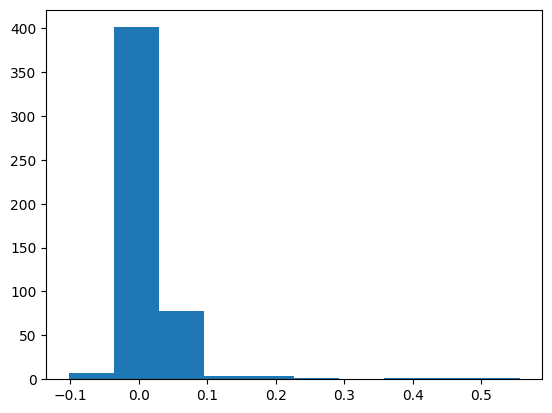

In [55]:
plt.hist(train_df['fitness'])

In [94]:
enz_df.sample(500)['fitness'].max()

0.5942810924111926

In [95]:
run_meta_data

{'round': [1, 2, 3, 4, 5],
 'train_spearmanr': [0.13177215346156287,
  0.24878130104961713,
  0.355350303687189,
  0.588415046389316,
  0.999926576041881],
 'top1k_spearmanr': [0.03566586708746767,
  -0.06837148046950894,
  -0.11028610448331323,
  0.0071347282691501535,
  0.02388608388608389],
 'top_candidate': [0.1948656992294483,
  0.2860665841157576,
  0.3751036325808242,
  0.4265960080620298,
  0.5560594437748744],
 'start_dataset': ['459e5208', '459e5208', '459e5208', '459e5208', '459e5208'],
 'test_run_id': ['0b74f691', '0b74f691', '0b74f691', '0b74f691', '0b74f691']}

In [29]:
c[1]

'DDHR'

In [31]:
c[1] in train_df['seq'].tolist()

False

In [116]:
start_.split('/')[-1].split('_')

['4dc03612', 'pos', 'start', '1', 'pool.csv']

In [5]:
ls ./arnold_data/run_metadata/long30round

dataset_4dc03612_test_run_40045fbd_run_meta_data.csv
dataset_4dc03612_test_run_40045fbd_seq_meta_data.csv
dataset_4dc03612_test_run_53cb8d7e_run_meta_data.csv
dataset_4dc03612_test_run_53cb8d7e_seq_meta_data.csv
dataset_4dc03612_test_run_801eee4c_run_meta_data.csv
dataset_4dc03612_test_run_801eee4c_seq_meta_data.csv
dataset_5dbed10e_test_run_930516a5_run_meta_data.csv
dataset_5dbed10e_test_run_930516a5_seq_meta_data.csv
dataset_ad3295f8_test_run_0cabd7e4_run_meta_data.csv
dataset_ad3295f8_test_run_0cabd7e4_seq_meta_data.csv
dataset_ad3295f8_test_run_1458042d_run_meta_data.csv
dataset_ad3295f8_test_run_1458042d_seq_meta_data.csv
dataset_ad3295f8_test_run_eed010e1_run_meta_data.csv
dataset_ad3295f8_test_run_eed010e1_seq_meta_data.csv
dataset_fdd9f3ad_test_run_46de0e5d_run_meta_data.csv
dataset_fdd9f3ad_test_run_46de0e5d_seq_meta_data.csv
dataset_fdd9f3ad_test_run_b57de569_run_meta_data.csv
dataset_fdd9f3ad_test_run_b57de569_seq_meta_data.csv
dataset_fdd9f3ad_test_run_f4ff483b_run_meta_da

### analysis from sym runs

In [2]:
start_csvs = glob.glob('./arnold_data/*.csv')
uids = []
for x in start_csvs:
    uids.append(x.split('/')[-1].split('_pos')[0])
uids = list(set(uids))


#run_datas = glob.glob(f'./arnold_data/run_metadata/15_round/*.csv')
#run_datas = glob.glob(f'./arnold_data/run_metadata/qEI/*.csv')
run_datas = glob.glob(f'./arnold_data/run_metadata/long30round/*.csv')


all_run_data_list = []
all_seq_data_list = []

for uid in uids:
    
    matches = glob.glob(f'./arnold_data/*{uid}_pos_start*')
    matches.sort()

    start_df = pd.read_csv(matches[0])
    pool_df = pd.read_csv(matches[1])
    
    max_start_fitness = start_df['fitness'].max()
    num_pos_start = int(matches[0].split('_')[-2])
    
    runs = [r for r in run_datas if uid in r]
    runs.sort()
    
    for i in range(len(runs)//2):
        run_data = pd.read_csv(runs[i*2])
        run_data['num_pos_start'] = num_pos_start
        run_data['max_start_fitness'] = max_start_fitness
        seq_data = pd.read_csv(runs[i*2+1])
        seq_data['dataset_id'] = uid
        seq_data['run_id'] = runs[i*2].split('_')[-4]
        
        all_run_data_list.append(run_data)
        all_seq_data_list.append(seq_data)
        

all_run_data = pd.concat(all_run_data_list)
all_seq_data = pd.concat(all_seq_data_list)

all_run_data["regret"] = 1-all_run_data["top_candidate"]

In [3]:
all_run_data

,Unnamed: 0,round,train_spearmanr,top1k_spearmanr,top_candidate,start_dataset,test_run_id,num_pos_start,max_start_fitness,regret
0,0,1,0.265491,0.023557,0.479912,ad3295f8,0cabd7e4,5,0.479912,0.520088
1,1,2,0.999845,0.213115,0.505593,ad3295f8,0cabd7e4,5,0.479912,0.494407
2,2,3,0.999950,0.240556,0.664727,ad3295f8,0cabd7e4,5,0.479912,0.335273
3,3,4,0.999961,0.322573,0.682997,ad3295f8,0cabd7e4,5,0.479912,0.317003
4,4,5,0.999439,0.385115,0.691943,ad3295f8,0cabd7e4,5,0.479912,0.308057
...,...,...,...,...,...,...,...,...,...,...
25,25,26,0.840302,0.596952,0.909769,459e5208,ac27d2ec,1,0.194866,0.090231
26,26,27,0.854716,0.593408,0.909769,459e5208,ac27d2ec,1,0.194866,0.090231
27,27,28,0.756470,0.656859,0.909769,459e5208,ac27d2ec,1,0.194866,0.090231
28,28,29,0.795227,0.635768,0.909769,459e5208,ac27d2ec,1,0.194866,0.090231


In [4]:
last_round_data = all_run_data[all_run_data['round']==30]

In [5]:
last_round_data

,Unnamed: 0,round,train_spearmanr,top1k_spearmanr,top_candidate,start_dataset,test_run_id,num_pos_start,max_start_fitness,regret
29,29,30,0.808458,0.601590,0.922559,ad3295f8,0cabd7e4,5,0.479912,0.077441
29,29,30,0.814919,0.641730,0.932034,ad3295f8,1458042d,5,0.479912,0.067966
29,29,30,0.765995,0.627773,1.000000,ad3295f8,eed010e1,5,0.479912,0.000000
29,29,30,0.711632,0.617528,1.000000,5dbed10e,12860f71,0,0.053898,0.000000
29,29,30,0.787665,0.657741,1.000000,5dbed10e,657b9c28,0,0.053898,0.000000
29,29,30,0.800311,0.585579,1.000000,5dbed10e,930516a5,0,0.053898,0.000000
29,29,30,0.776062,0.635265,1.000000,598b8758,1e1ba719,5,0.560806,0.000000
29,29,30,0.787058,0.628028,0.922559,598b8758,ad99fbd9,5,0.560806,0.077441
29,29,30,0.817946,0.659798,1.000000,598b8758,cc492b33,5,0.560806,0.000000
29,29,30,0.778900,0.637712,1.000000,52b94d16,3834380000.0,10,0.267211,0.000000


In [6]:
max_vals = []
for i in range(500):
    tmp = enz_df.sample(3000)['fitness']
    max_vals.append(tmp.max())
    

In [7]:
comparison_datas = {
    "method":[],
    "regret":[],
}

comparison_datas["regret"] += [1-x for x in max_vals]
comparison_datas["method"] += ['random sample max' for x in max_vals]

comparison_datas["regret"] += [1-x for x in last_round_data['top_candidate'].tolist()]
comparison_datas["method"] += ['optimized sample max' for x in last_round_data['top_candidate'].tolist()]

Text(0.5, 0, '')

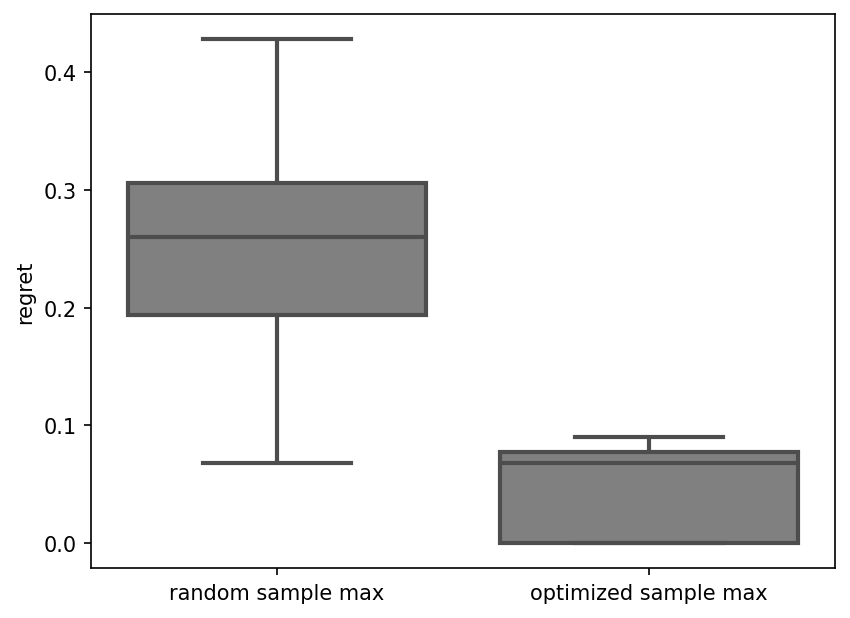

In [8]:
plt.figure(dpi=150)
sns.boxplot(data=comparison_datas, x='method', y='regret', showfliers=False, color='grey',linewidth=2)
plt.xlabel('')

In [29]:
last_round_data.sort_values('top_candidate',ascending=False)

,Unnamed: 0,round,train_spearmanr,top1k_spearmanr,top_candidate,start_dataset,test_run_id,num_pos_start,max_start_fitness,regret
29,29,30,0.765995,0.627773,1.000000,ad3295f8,eed010e1,5,0.479912,0.000000
29,29,30,0.711632,0.617528,1.000000,5dbed10e,12860f71,0,0.053898,0.000000
29,29,30,0.787665,0.657741,1.000000,5dbed10e,657b9c28,0,0.053898,0.000000
29,29,30,0.800311,0.585579,1.000000,5dbed10e,930516a5,0,0.053898,0.000000
29,29,30,0.776062,0.635265,1.000000,598b8758,1e1ba719,5,0.560806,0.000000
29,29,30,0.817946,0.659798,1.000000,598b8758,cc492b33,5,0.560806,0.000000
29,29,30,0.778900,0.637712,1.000000,52b94d16,3834380000.0,10,0.267211,0.000000
29,29,30,0.772916,0.648630,1.000000,4dc03612,40045fbd,1,0.158496,0.000000
29,29,30,0.785083,0.631654,1.000000,4dc03612,53cb8d7e,1,0.158496,0.000000
29,29,30,0.765146,0.612074,0.932034,4dc03612,801eee4c,1,0.158496,0.067966


In [29]:
enz_df.sort_values('fitness',ascending=False)[:10]

,AAs,AA1,AA2,AA3,AA4,# Stop,fitness,active
12849,AIKG,A,I,K,G,0.0,1.000000,True
22948,CLKG,C,L,K,G,0.0,0.932034,True
170146,VLKG,V,L,K,G,0.0,0.922559,True
13731,ALKG,A,L,K,G,0.0,0.916559,True
22074,CIKG,C,I,K,G,0.0,0.909769,True
77216,IIKG,I,I,K,G,0.0,0.895147,True
169264,VIKG,V,I,K,G,0.0,0.882466,True
17255,AVKG,A,V,K,G,0.0,0.847924,True
78094,ILKG,I,L,K,G,0.0,0.845869,True
26462,CVKG,C,V,K,G,0.0,0.841400,True


<Axes: xlabel='round', ylabel='fitness'>

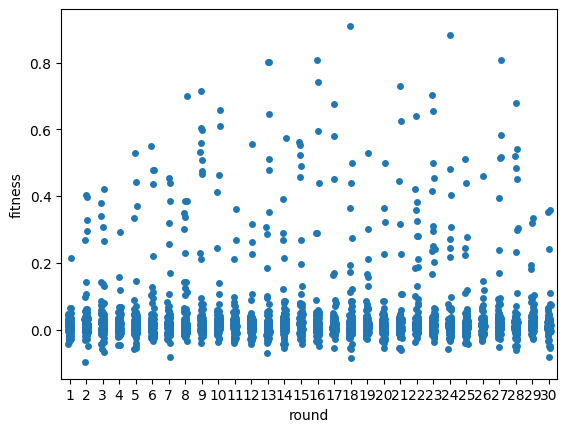

In [30]:
tmp = all_seq_data[all_seq_data['run_id']=='4b9f7e55']
sns.stripplot(data=tmp,x='round',y='fitness')

<Axes: xlabel='round', ylabel='fitness'>

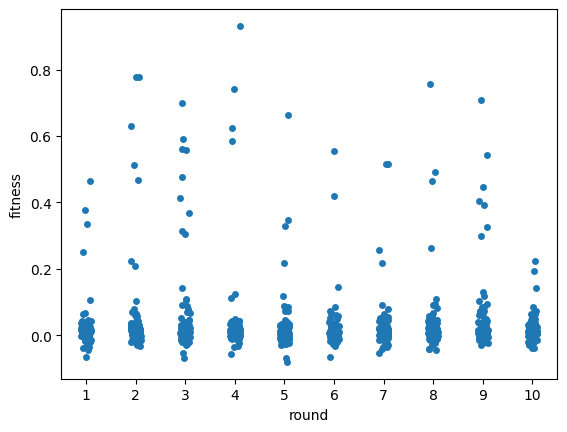

In [295]:
tmp = all_seq_data[all_seq_data['run_id']=='3d4756bd']
sns.stripplot(data=tmp,x='round',y='fitness')

In [274]:
with_random_data

,Unnamed: 0,round,train_spearmanr,top1k_spearmanr,top_candidate,start_dataset,test_run_id,num_pos_start,max_start_fitness,regret,labels
0,0.0,1,0.292596,0.017996,0.447268,ef355a53,1d84d0c6,10,0.447268,0.552732,10
1,1.0,2,0.999916,0.133706,0.699833,ef355a53,1d84d0c6,10,0.447268,0.300167,10
2,2.0,3,0.999981,0.227313,0.699833,ef355a53,1d84d0c6,10,0.447268,0.300167,10
3,3.0,4,0.999947,0.282723,0.699833,ef355a53,1d84d0c6,10,0.447268,0.300167,10
4,4.0,5,0.999648,0.310959,0.699833,ef355a53,1d84d0c6,10,0.447268,0.300167,10
...,...,...,...,...,...,...,...,...,...,...,...
25,NaN,6,NaN,NaN,NaN,NaN,NaN,random,NaN,0.361647,random
26,NaN,7,NaN,NaN,NaN,NaN,NaN,random,NaN,0.361647,random
27,NaN,8,NaN,NaN,NaN,NaN,NaN,random,NaN,0.361647,random
28,NaN,9,NaN,NaN,NaN,NaN,NaN,random,NaN,0.361647,random


<Axes: xlabel='round', ylabel='regret'>

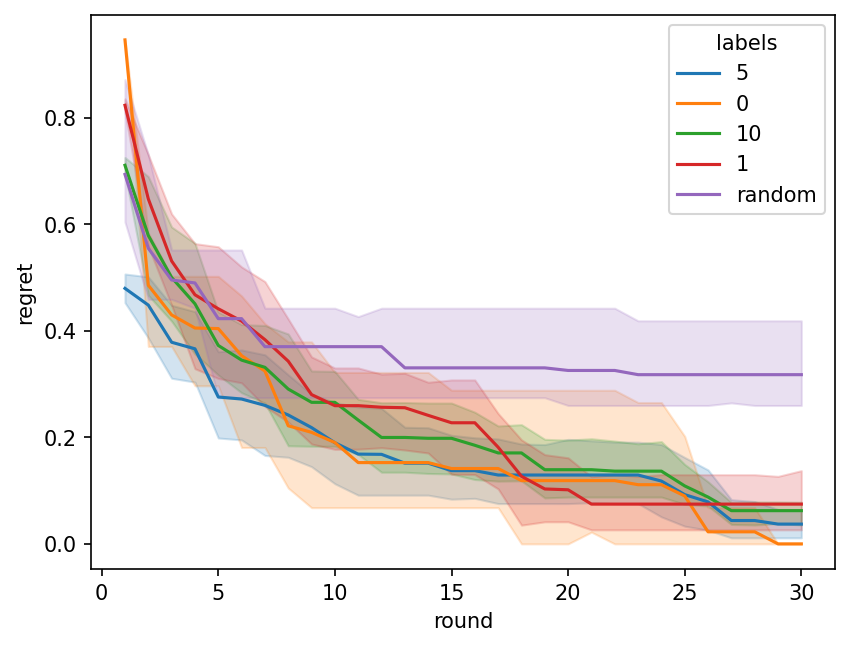

In [27]:
subset = all_run_data[all_run_data['num_pos_start']==0]
subset = all_run_data
with_random_data = pd.concat([subset,pd.DataFrame(random_data)])

with_random_data['labels'] =[str(x) for x in with_random_data['num_pos_start'].tolist()]
plt.figure(dpi=150)
sns.lineplot(data=with_random_data,x='round',y='regret',hue='labels',palette='tab10')


In [315]:
30000/0.02

1500000.0

Text(0, 0.5, 'top 3% spearmanr')

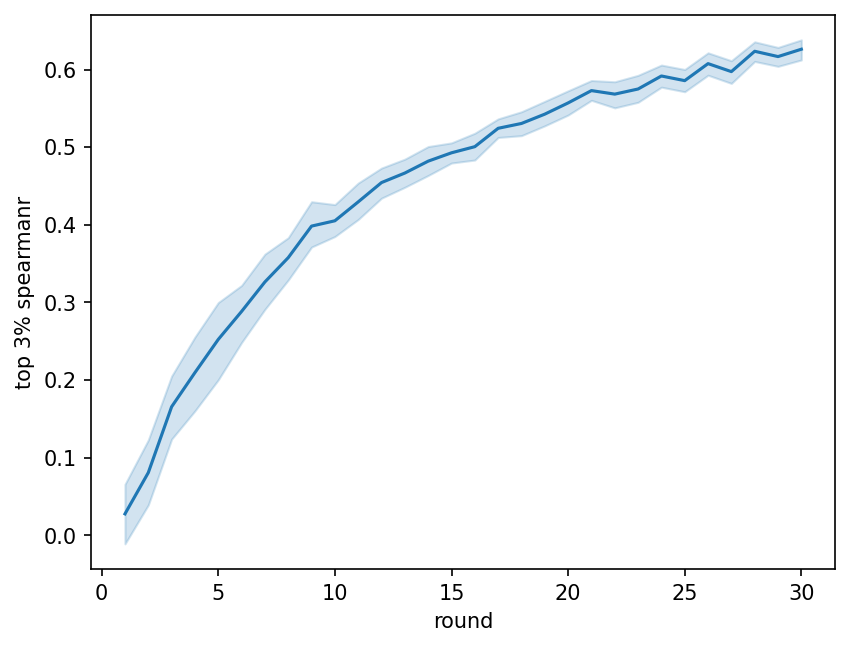

In [9]:
plt.figure(dpi=150)
sns.lineplot(data=all_run_data,x='round',y='top1k_spearmanr',)
plt.ylabel('top 3% spearmanr')


In [229]:
5000/160000

0.03125

In [26]:
random_data = {
    'num_pos_start':[],
    'regret':[],
    'round':[],

    
}
for j in range(3):
    
    max_ = 0

    for i in range(30):
    
        tmp = enz_df.sample(100)['fitness']
        
        if tmp.max() > max_:
            max_ = tmp.max()

        random_data['num_pos_start'].append('random')
        random_data['regret'].append(1-max_)
        random_data['round'].append(i+1)

,Unnamed: 0,round,train_spearmanr,top1k_spearmanr,top_candidate,start_dataset,test_run_id,num_pos_start,max_start_fitness,regret
0,0.0,1.0,0.458055,-0.017611,0.447268,ef355a53,20bc3580,10,0.447268,0.552732
1,1.0,2.0,0.999656,0.095627,0.541187,ef355a53,20bc3580,10,0.447268,0.458813
2,2.0,3.0,0.999907,0.188808,0.621590,ef355a53,20bc3580,10,0.447268,0.378410
3,3.0,4.0,0.999938,0.213653,0.621590,ef355a53,20bc3580,10,0.447268,0.378410
4,4.0,5.0,0.999101,0.217029,0.746142,ef355a53,20bc3580,10,0.447268,0.253858
...,...,...,...,...,...,...,...,...,...,...
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,random,NaN,0.469774
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,random,NaN,0.923720
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,random,NaN,0.533294
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,random,NaN,0.787310


In [35]:
sample_sizes = [5000,10000,20000,50000,75000]
max_candidates = []

for x in sample_sizes:
    cands = []
    for i in range(100):
        tmp = enz_df.sample(x)['fitness']
        cands.append(tmp.max())
    max_candidates.append(cands)


In [36]:
for x,s in zip(max_candidates,sample_sizes):
    frac_in_top_5 = sum([1 for y in x if y > 0.9])/len(x)
    
    print(f'num samples {s} : fraction in top5 {frac_in_top_5}')

num samples 5000 : fraction in top5 0.16
num samples 10000 : fraction in top5 0.18
num samples 20000 : fraction in top5 0.43
num samples 50000 : fraction in top5 0.81
num samples 75000 : fraction in top5 0.96


In [43]:
enz_df[enz_df['fitness']>0.4]

,AAs,AA1,AA2,AA3,AA4,# Stop,fitness,active
9630,AACS,A,A,C,S,0.0,0.467350,True
9756,AAIS,A,A,I,S,0.0,0.432752,True
9767,AAKG,A,A,K,G,0.0,0.623141,True
9798,AALS,A,A,L,S,0.0,0.521736,True
9819,AAMS,A,A,M,S,0.0,0.432285,True
...,...,...,...,...,...,...,...,...
173737,VVNG,V,V,N,G,0.0,0.451119,True
173779,VVQG,V,V,Q,G,0.0,0.445450,True
173821,VVSG,V,V,S,G,0.0,0.617425,True
173842,VVTG,V,V,T,G,0.0,0.596120,True


In [44]:
5/1151

0.004344048653344918